In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
from sklearn.model_selection import train_test_split
from PIL import UnidentifiedImageError


In [2]:
# Constants
IMG_HEIGHT, IMG_WIDTH = 360, 363
BATCH_SIZE = 32
EPOCHS = 20
DATASET_DIR = '/kaggle/input/microscopic-peripheral-blood-cell-images-mendeley/PBC_dataset_normal_DIB'
SEED = 42  # Seed for reproducibility

In [3]:
# Step 1: Programmatically create file lists for train, validation, and test sets
def create_data_splits(dataset_dir, test_split=0.1, val_split=0.1):
    train_files, val_files, test_files = [], [], []
    for class_dir in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_dir)
        if os.path.isdir(class_path):
            files = [os.path.join(class_dir, f) for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            train, temp = train_test_split(files, test_size=(val_split + test_split), random_state=SEED)
            val, test = train_test_split(temp, test_size=test_split / (val_split + test_split), random_state=SEED)
            train_files.extend(train)
            val_files.extend(val)
            test_files.extend(test)
    return train_files, val_files, test_files

In [4]:
train_files, val_files, test_files = create_data_splits(DATASET_DIR)

In [5]:
# Step 2: Custom Data Generators to load images from specific file lists
class_indices = {class_name: idx for idx, class_name in enumerate(sorted(os.listdir(DATASET_DIR)))}

In [6]:
def custom_generator(file_list, dataset_dir, batch_size, img_height, img_width, shuffle=True):
    while True:
        if shuffle:
            batch_paths = np.random.choice(file_list, batch_size)
        else:
            batch_paths = file_list[:batch_size]
            file_list = file_list[batch_size:] + batch_paths  # Cycle through data if not shuffled
        
        batch_input, batch_output = [], []
        for file_path in batch_paths:
            try:
                full_path = os.path.join(dataset_dir, file_path)
                img = tf.keras.preprocessing.image.load_img(full_path, target_size=(img_height, img_width))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                class_name = file_path.split(os.sep)[0]
                label = class_indices[class_name]
                batch_input.append(img_array)
                batch_output.append(label)
            except (UnidentifiedImageError, OSError) as e:
                print(f"\nSkipping unreadable file: {file_path}. Error: {e}")
                continue
        
        if batch_input and batch_output:
            batch_x = np.array(batch_input)
            batch_y = tf.keras.utils.to_categorical(batch_output, num_classes=len(class_indices))
            yield batch_x, batch_y


In [8]:
# Initialize generators
train_generator = custom_generator(train_files, DATASET_DIR, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH)
validation_generator = custom_generator(val_files, DATASET_DIR, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH)

In [9]:
# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(len(class_indices), activation='softmax')
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 358, 361, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 358, 361, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 179, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 179, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 177, 178, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 177, 178, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 88, 89, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 88, 89, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 86, 87, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 86, 87, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 43, 43, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 43, 43, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 236672)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    30,294,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,397,832 (115.96 MB)

 Trainable params: 30,397,000 (115.96 MB)

 Non-trainable params: 832 (3.25 KB)

In [11]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [12]:
# Calculate steps per epoch based on available data
train_steps_per_epoch = len(train_files) // BATCH_SIZE
val_steps_per_epoch = len(val_files) // BATCH_SIZE
test_steps = len(test_files) // BATCH_SIZE

In [13]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping]
)


Epoch 1/20


I0000 00:00:1731474872.213498      96 service.cc:145] XLA service 0x790558006140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731474872.213560      96 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/427 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.1484 - loss: 2.9760   

I0000 00:00:1731474886.513094      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


427/427 ━━━━━━━━━━━━━━━━━━━━ 151s 313ms/step - accuracy: 0.5836 - loss: 1.2794 - val_accuracy: 0.6787 - val_loss: 0.8561
Epoch 2/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 96s 226ms/step - accuracy: 0.8799 - loss: 0.3663 - val_accuracy: 0.7948 - val_loss: 0.7152
Epoch 3/20
 66/427 ━━━━━━━━━━━━━━━━━━━━ 1:03 177ms/step - accuracy: 0.9226 - loss: 0.2683
Skipping unreadable file: neutrophil/.DS_169665.jpg. Error: cannot identify image file <_io.BytesIO object at 0x79059829e1b0>
274/427 ━━━━━━━━━━━━━━━━━━━━ 33s 220ms/step - accuracy: 0.9196 - loss: 0.2661
Skipping unreadable file: neutrophil/.DS_169665.jpg. Error: cannot identify image file <_io.BytesIO object at 0x7905981985e0>
383/427 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.9191 - loss: 0.2657
Skipping unreadable file: neutrophil/.DS_169665.jpg. Error: cannot identify image file <_io.BytesIO object at 0x790598198860>
427/427 ━━━━━━━━━━━━━━━━━━━━ 96s 224ms/step - accuracy: 0.9189 - loss: 0.2654 - val_accuracy: 0.5024 - val_loss: 3.0739
Epoch

In [14]:
# Re-create the test generator without shuffling to match the true labels order
test_generator = custom_generator(test_files, DATASET_DIR, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, shuffle=False)

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 335ms/step - accuracy: 0.7499 - loss: 0.6989
Test Loss: 0.7724738121032715
Test Accuracy: 0.7818396091461182


In [16]:
# Calculate the exact number of test samples
total_test_samples = len(test_files)

In [17]:
# Predict on the test data, ensuring the prediction array length matches the test set
predictions = model.predict(test_generator, steps=(total_test_samples // BATCH_SIZE) + 1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step


In [18]:
# Obtain predicted classes and match the length of `true_classes`
predicted_classes = np.argmax(predictions, axis=1)

In [37]:
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


Classification Report:
               precision    recall  f1-score   support

    basophil       0.97      0.93      0.95       122
  eosinophil       1.00      0.98      0.99       312
erythroblast       0.94      0.97      0.96       156
          ig       0.91      0.87      0.89       290
  lymphocyte       0.96      0.90      0.93       122
    monocyte       0.80      0.89      0.85       142
  neutrophil       0.94      0.98      0.96       333
    platelet       1.00      0.98      0.99       235

    accuracy                           0.94      1712
   macro avg       0.94      0.94      0.94      1712
weighted avg       0.95      0.94      0.94      1712

Confusion Matrix:
 [[113   0   0   6   0   0   3   0]
 [  0 305   0   0   0   1   5   1]
 [  0   0 152   0   4   0   0   0]
 [  2   0   2 251   0  24  11   0]
 [  0   0   2   3 110   6   1   0]
 [  0   0   2  13   0 127   0   0]
 [  1   0   0   4   0   0 328   0]
 [  0   0   4   0   0   0   0 231]]


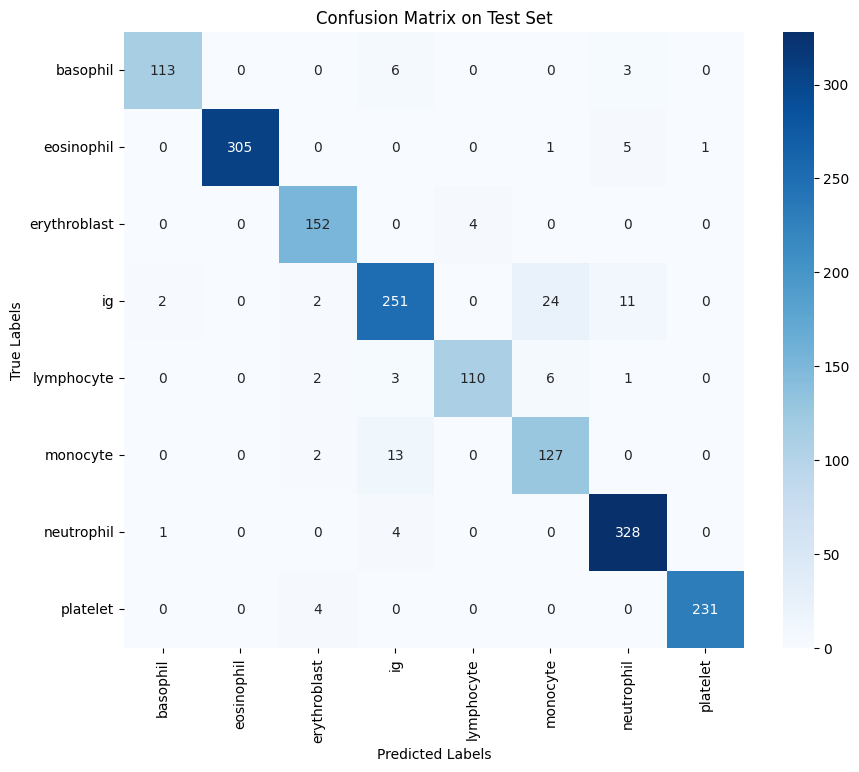

In [38]:
# Plotting Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(class_indices.keys()),
            yticklabels=list(class_indices.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [39]:
# Save the model
model.save("single_blood_cell_classifier.h5")
model.save("single_blood_cell_classifier.keras")

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np

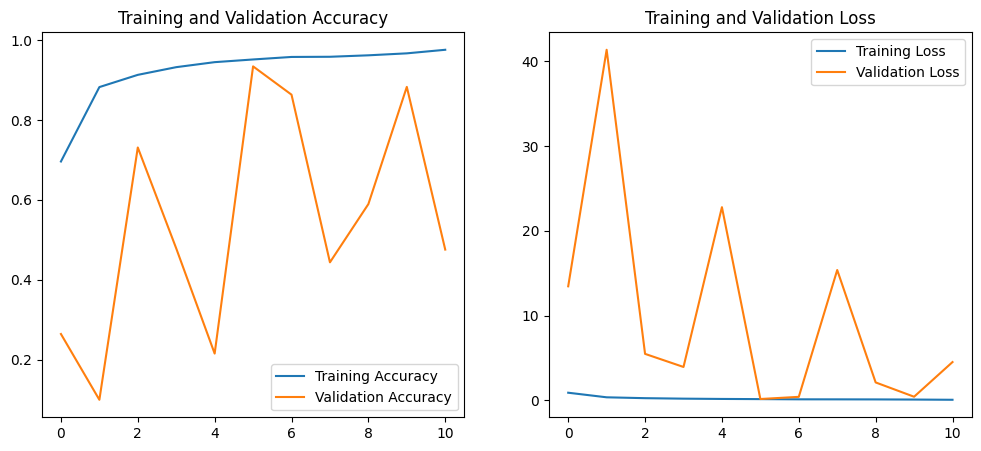

In [41]:
# Plot training history (Accuracy and Loss)
def plot_training_history(history):
    """Plot training and validation accuracy/loss curves."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Call plot function for training history
plot_training_history(history)

In [44]:
# ROC Curve for each class (One-vs-Rest approach)
def plot_roc_curve(y_true, y_pred, class_labels):
    """Plot ROC curves for each class."""
    y_true_binarized = label_binarize(y_true, classes=list(range(len(class_labels))))
    n_classes = y_true_binarized.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [45]:
# Precision-Recall Curve for each class
def plot_precision_recall_curve(y_true, y_pred, class_labels):
    """Plot Precision-Recall curves for each class."""
    y_true_binarized = label_binarize(y_true, classes=list(range(len(class_labels))))
    n_classes = y_true_binarized.shape[1]

    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y_true_binarized[:, i], y_pred[:, i])

    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'PR curve of class {class_labels[i]} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multi-class Precision-Recall Curve')
    plt.legend(loc="best")
    plt.show()

54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step


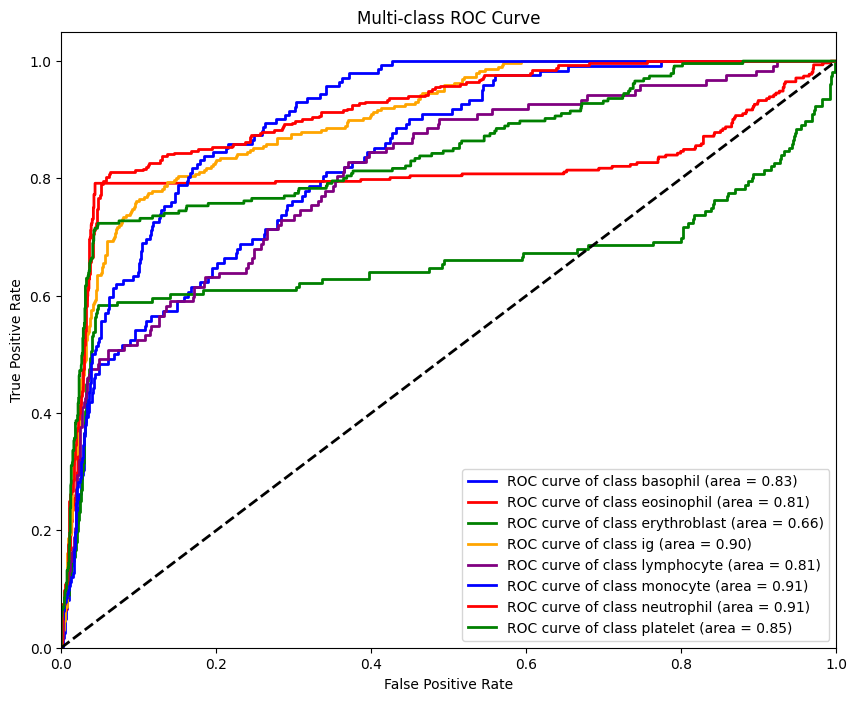

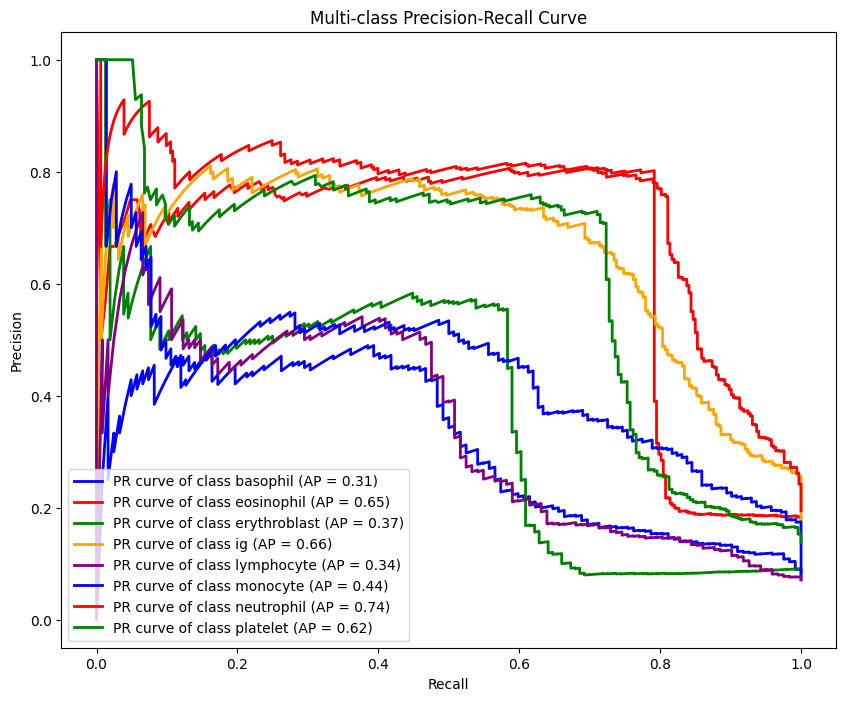

In [47]:
# Generate predictions with adjusted steps to ensure all test samples are covered
predicted_probabilities = model.predict(test_generator, steps=(len(test_files) // BATCH_SIZE) + 1)

# Ensure `predicted_probabilities` matches `true_labels` in length
predicted_probabilities = predicted_probabilities[:len(test_files)]
true_labels = [class_indices[file_path.split(os.sep)[0]] for file_path in test_files]

# Binarize `true_labels` for multi-class ROC and Precision-Recall
true_labels_binarized = label_binarize(true_labels, classes=list(range(len(class_indices))))

# Plot ROC and Precision-Recall curves with matched lengths
plot_roc_curve(true_labels_binarized, predicted_probabilities, list(class_indices.keys()))
plot_precision_recall_curve(true_labels_binarized, predicted_probabilities, list(class_indices.keys()))
